# QC Simulation of Heston Model according to [Woerner, 2020]

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

# importing Qiskit
import qiskit
from qiskit import *

# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector

aer_sim = Aer.get_backend('aer_simulator')

## 1. Defining the algorithm operator

In this section, we define the quantum operator for a simplified Heston model with explicit encoding of the distribution. This can be found in Appendix B of the paper Vazquez/Woerner: "Efficient State Preparation for Quantum Amplitude Estimation", 2020

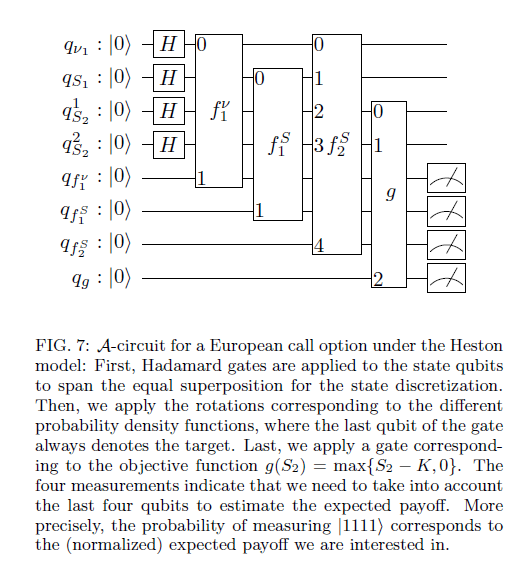

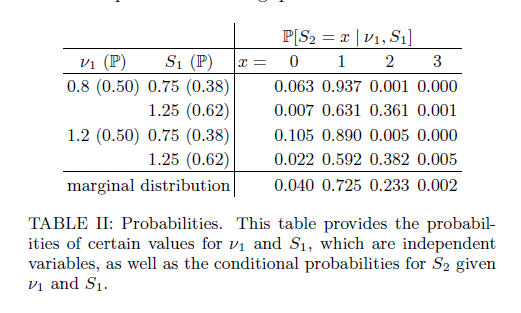

In [2]:
# Define probabilities
probs = {'v': [0.5, 0.5],
         's1': [0.38, 0.62],
        's2': [[0.063, 0.937, 0.001, 0.0], 
               [0.007, 0.631, 0.361, 0.001],
               [0.105, 0.890, 0.005, 0.0],
               [0.022, 0.592, 0.382, 0.00338709677419331]]}
agl = lambda x: 2 * np.arcsin(np.sqrt(x))
angles = {'v': [agl(x) for x in probs.get('v')],
         's1': [agl(x) for x in probs.get('s1')],
         's2': [[agl(x) for x in y] for y in probs.get('s2')],}
#print(angles.get('s2'))

In [3]:
# Helper functions
def xif(qc, q, c):
    if c == 0:
        qc.x(q)
        
def mcry(theta, nControls):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc = qc.to_gate()
    qc.label = "mcry(" + str(round(100*theta)/100) + ")"
    cqc = qc.control(nControls)
    return cqc

def barrif(qc, b):
    if b:
        qc.barrier()


In [4]:
# Rotations on the ancilla qubits to generate distribution and payoff function
def vRot(withBarrier = False):
    qc = QuantumCircuit(8)
    for q in range(2):
        xif(qc, 0, q)
        qc.cry(angles.get('v')[q], 0, 4)
        xif(qc, 0, q)
        barrif(qc, withBarrier)
    return qc
        
def s1Rot(withBarrier = False):
    qc = QuantumCircuit(8)
    for q in range(2):
        xif(qc, 1, q)
        qc.cry(angles.get('s1')[q], 1, 5)
        xif(qc, 1, q)
        barrif(qc, withBarrier)
    return qc

def s2Rot(withBarrier = False):
    qc = QuantumCircuit(8)
    crs = [(x,y) for x in range(2) for y in range(2)]
    for (v, s1) in crs:
        for (q1, q2) in crs:
            row = 2 * v + s1
            col = 2 * q1 + q2
            xif(qc, 0, v)
            xif(qc, 1, s1)
            xif(qc, 2, q1)
            xif(qc, 3, q2)
            qc.append(mcry(angles.get('s2')[row][col], 4), [0, 1, 2, 3, 6])
            xif(qc, 3, q2)
            xif(qc, 2, q1)
            xif(qc, 1, s1)
            xif(qc, 0, v)
            barrif(qc, withBarrier)
    return qc

def gRot(withBarrier = False):
    # Controlled rotation for the payoff function
    # g(S2) = max(0, S2 - 1), which is normalized to 0.5 * g(S2) \in [0,1]
    # More precisely g(0) = g(1) = 0, g(2) = 0.5, g(3) = 1
    # In our encoding, 0 = 00, 1 = 01, 2 = 10, 3 = 11, 
    # hence we require a rotation by pi/2 if q1=1 and another pi/2 if q2=1
    qc = QuantumCircuit(8)
    qc.cry(0.5 * math.pi, 2, 7)
    qc.append(mcry(0.5 * math.pi, 2), [2, 3, 7])
    barrif(qc, withBarrier)
    return qc


In [5]:
# Build the algorithm operator 
def woernerA(toGate = True):
    qc = QuantumCircuit(8)
    # Hadamard for uniform superposition
    qc.h(range(4))
    # Controlled rotation for v ancilla
    qc = qc.compose(vRot(not toGate))
    # Controlled rotation for s1 ancilla
    qc = qc.compose(s1Rot(not toGate))
    # Controlled rotation for s2 ancilla
    qc = qc.compose(s2Rot(not toGate))
    # Controlled rotation for the payoff function
    qc = qc.compose(gRot(not toGate))
    if toGate:
        qc = qc.to_gate()
    qc.label = "A"
    return qc

In [6]:
a = woernerA(False)
a.draw()

┌───┐┌───┐           ┌───┐ ░             ░                          ░ »
q_0: ┤ H ├┤ X ├─────■─────┤ X ├─░──────■──────░──────────────────────────░─»
     ├───┤└───┘     │     └───┘ ░      │      ░ ┌───┐              ┌───┐ ░ »
q_1: ┤ H ├──────────┼───────────░──────┼──────░─┤ X ├──────■───────┤ X ├─░─»
     ├───┤          │           ░      │      ░ └───┘      │       └───┘ ░ »
q_2: ┤ H ├──────────┼───────────░──────┼──────░────────────┼─────────────░─»
     ├───┤          │           ░      │      ░            │             ░ »
q_3: ┤ H ├──────────┼───────────░──────┼──────░────────────┼─────────────░─»
     └───┘     ┌────┴────┐      ░ ┌────┴────┐ ░            │             ░ »
q_4: ──────────┤ Ry(π/2) ├──────░─┤ Ry(π/2) ├─░────────────┼─────────────░─»
               └─────────┘      ░ └─────────┘ ░      ┌─────┴──────┐      ░ »
q_5: ───────────────────────────░─────────────░──────┤ Ry(1.3284) ├──────░─»
                                ░             ░      └────────────┘      ░ »
q_6: ───────────────────────────░─────────────░──────────────────────────░─»
                                ░             ░                          ░ »
q_7: ───────────────────────────░─────────────░──────────────────────────░─»
                                ░             ░                          ░ »
«                    ░ ┌───┐              ┌───┐ ░ ┌───┐              ┌───┐ ░ »
«q_0: ───────────────░─┤ X ├──────■───────┤ X ├─░─┤ X ├──────■───────┤ X ├─░─»
«                    ░ ├───┤      │       ├───┤ ░ ├───┤      │       ├───┤ ░ »
«q_1: ──────■────────░─┤ X ├──────■───────┤ X ├─░─┤ X ├──────■───────┤ X ├─░─»
«           │        ░ ├───┤      │       ├───┤ ░ ├───┤      │       ├───┤ ░ »
«q_2: ──────┼────────░─┤ X ├──────■───────┤ X ├─░─┤ X ├──────■───────┤ X ├─░─»
«           │        ░ ├───┤      │       ├───┤ ░ └───┘      │       └───┘ ░ »
«q_3: ──────┼────────░─┤ X ├──────■───────┤ X ├─░────────────■─────────────░─»
«           │        ░ └───┘      │       └───┘ ░            │             ░ »
«q_4: ──────┼────────░────────────┼─────────────░────────────┼─────────────░─»
«     ┌─────┴──────┐ ░            │             ░            │             ░ »
«q_5: ┤ Ry(1.8132) ├─░────────────┼─────────────░────────────┼─────────────░─»
«     └────────────┘ ░      ┌─────┴──────┐      ░      ┌─────┴──────┐      ░ »
«q_6: ───────────────░──────┤ mcry(0.51) ├──────░──────┤ mcry(2.63) ├──────░─»
«                    ░      └────────────┘      ░      └────────────┘      ░ »
«q_7: ───────────────░──────────────────────────░──────────────────────────░─»
«                    ░                          ░                          ░ »
«     ┌───┐              ┌───┐ ░ ┌───┐             ┌───┐ ░ ┌───┐              »
«q_0: ┤ X ├──────■───────┤ X ├─░─┤ X ├──────■──────┤ X ├─░─┤ X ├──────■───────»
«     ├───┤      │       ├───┤ ░ ├───┤      │      ├───┤ ░ └───┘      │       »
«q_1: ┤ X ├──────■───────┤ X ├─░─┤ X ├──────■──────┤ X ├─░────────────■───────»
«     └───┘      │       └───┘ ░ └───┘      │      └───┘ ░ ┌───┐      │       »
«q_2: ───────────■─────────────░────────────■────────────░─┤ X ├──────■───────»
«     ┌───┐      │       ┌───┐ ░            │            ░ ├───┤      │       »
«q_3: ┤ X ├──────■───────┤ X ├─░────────────■────────────░─┤ X ├──────■───────»
«     └───┘      │       └───┘ ░            │            ░ └───┘      │       »
«q_4: ───────────┼─────────────░────────────┼────────────░────────────┼───────»
«                │             ░            │            ░            │       »
«q_5: ───────────┼─────────────░────────────┼────────────░────────────┼───────»
«          ┌─────┴──────┐      ░      ┌─────┴─────┐      ░      ┌─────┴──────┐»
«q_6: ─────┤ mcry(0.06) ├──────░──────┤ mcry(0.0) ├──────░──────┤ mcry(0.17) ├»
«          └────────────┘      ░      └───────────┘      ░      └────────────┘»
«q_7: ─────────────────────────░─────────────────────────░────────────────────»
«                              ░                         ░               

In [7]:
qc_test = QuantumCircuit(8, 4)
qc_test.append(woernerA(), range(8))
#qc = qc.compose(woernerA(False))
qc_test.measure([4, 5, 6 ,7], range(4))
qc_test.draw()

┌────┐            
q_0: ┤0   ├────────────
     │    │            
q_1: ┤1   ├────────────
     │    │            
q_2: ┤2   ├────────────
     │    │            
q_3: ┤3   ├────────────
     │  A │┌─┐         
q_4: ┤4   ├┤M├─────────
     │    │└╥┘┌─┐      
q_5: ┤5   ├─╫─┤M├──────
     │    │ ║ └╥┘┌─┐   
q_6: ┤6   ├─╫──╫─┤M├───
     │    │ ║  ║ └╥┘┌─┐
q_7: ┤7   ├─╫──╫──╫─┤M├
     └────┘ ║  ║  ║ └╥┘
c: 4/═══════╩══╩══╩══╩═
            0  1  2  3

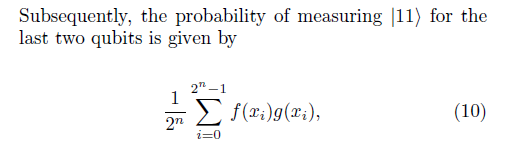

## 2. Testing the PV by direct simulation

In [8]:
# Calculate PV by direct simulation, i.e. measuring fraction of "good" states
# Note: This is equivalent to classical MC with 1/sqrt(shots) convergence
t_qc_test = transpile(qc_test, aer_sim)
qobj_test = assemble(t_qc_test)
shots = 10000
job_test = aer_sim.run(qobj_test, shots = shots)
hist_test = job_test.result().get_counts()
pv_test = (2**4) * hist_test.get('1111')/shots # see formula above for the prefactor 2^4
print('Expected payoff = ' + str(pv_test))

Expected payoff = 0.1072


## 3.  Calculating the PV by Quantum Amplitude Estimation


In this section, we calculate the PV (i.e. the probability of measuring a good state of the algorithm operator) by quantum amplitude estimation as described in the paper Brassard et al: Quantum Amplitude Amplification and Estimation, 2000

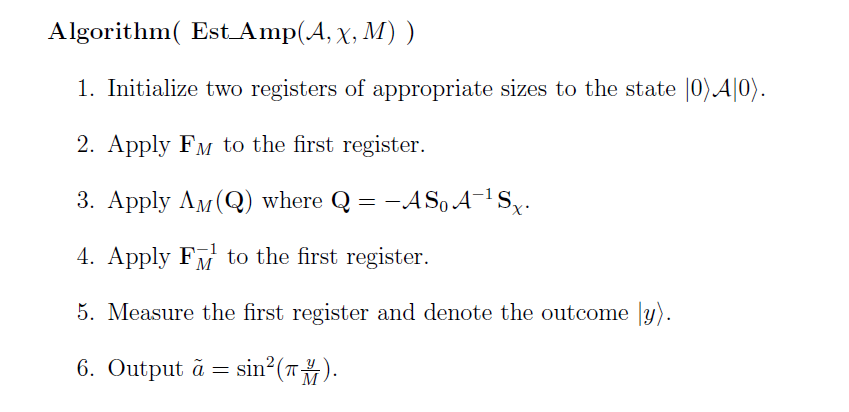

In [9]:
# Define sign flip operator for "good" states
# Note: good state is |1111>
def Sx():
    qc = QuantumCircuit(8)
    # Do multi-controlled-Z gate
    qc.h(7)
    qc.mct(list(range(4,7)), 7)  # multi-controlled-toffoli
    qc.h(7)
    qc = qc.to_gate()
    qc.label = "S1"
    return qc

In [10]:
# Define sign flip operator for zero state
def S0():
    qc = QuantumCircuit(8)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(8):
        qc.x(qubit)
    qc.h(7)
    qc.mct(list(range(7)), 7)  # multi-controlled-toffoli (converting |-> to -|->)
    qc.h(7)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(8):
        qc.x(qubit)
    qc = qc.to_gate()
    qc.label = "S0"
    return qc

In [11]:
# Define operator Q
# Note: We actually define -Q = +A S0 AT S1 instead of Q, i.e. we measure the amplitude of "bad states"
def Q():
    A = woernerA()
    AT = A.inverse()
    AT.label = "A†"
    qc = QuantumCircuit(8)
    qc.append(Sx(), range(8))
    qc.append(AT, range(8))
    qc.append(S0(), range(8))
    qc.append(A, range(8))
    qc.label = "-Q"
    return qc
    
    

In [12]:
# Define QFT (from Qiskit notebook "Quantum Counting")
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


In [13]:
# Build the QAE circuit
def qcQAE(t, n):
    qc_amp = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

    # Apply Hadamard to counting register
    for qubit in range(t):
        qc_amp.h(qubit)
    #qc.append(qft(4).to_gate(), range(t))

    # Apply A operator to algo register
    qc_amp.append(woernerA(),range(t, n+t))

    # Apply controlled Q operators
    cQ = Q().to_gate()
    cQ.label = "Q"
    cQ = cQ.control()
    iterations = 1
    for qubit in range(t):
        for i in range(iterations):
            qc_amp.append(cQ, [qubit] + [*range(t, n+t)])
        iterations *= 2

    # Do inverse QFT on counting qubits
    qft_dagger = qft(t).to_gate().inverse()
    qft_dagger.label = "QFT†"
    qc_amp.append(qft_dagger, range(t))

    # Measure counting qubits
    qc_amp.measure(range(t), range(t))
    return qc_amp

In [14]:
# Note: We expect pv = 0.11. We have 16*sin(pi/32)^2 = 0.6 and 16*sin(pi/64)^2=0.15.
# Hence we need at least 5 counting qubits to get a pv different from zero
t = 5   # no. of counting qubits
n = 8   # no. of algo qubits
qc_amp = qcQAE(t, n)
qc_amp.draw()

┌───┐                                                                   »
 q_0: ┤ H ├───■───────────────────────────────────────────────────────────────»
      ├───┤   │                                                               »
 q_1: ┤ H ├───┼─────■─────■───────────────────────────────────────────────────»
      ├───┤   │     │     │                                                   »
 q_2: ┤ H ├───┼─────┼─────┼─────■─────■─────■─────■───────────────────────────»
      ├───┤   │     │     │     │     │     │     │                           »
 q_3: ┤ H ├───┼─────┼─────┼─────┼─────┼─────┼─────┼─────■─────■─────■─────■───»
      ├───┤   │     │     │     │     │     │     │     │     │     │     │   »
 q_4: ┤ H ├───┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼───»
      ├───┴┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐»
 q_5: ┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├»
      │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
 q_6: ┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├»
      │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
 q_7: ┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├»
      │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
 q_8: ┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├»
      │  A ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q │»
 q_9: ┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├»
      │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
q_10: ┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├»
      │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
q_11: ┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├»
      │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
q_12: ┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├»
      └────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘»
 c: 5/════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                                              »
« q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                              »
« q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                              »
« q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                              »
« q_3: ──■─────■─────■─────■───────────────────────────────────────────────────»
«        │     │     │     │                                                   »
« q_4: ──┼─────┼─────┼─────┼─────■─────■─────■─────■─────■─────■─────■─────■───»
«      ┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐»
« q_5: ┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├»
«      │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
« q_6: ┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├»
«      │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
« q_7: ┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├»
«      │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
« q_8: ┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├»
«      │  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q │»
« q_9: ┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├»
«      │    ││    ││    ││    ││    ││    ││    ││    ││    ││    

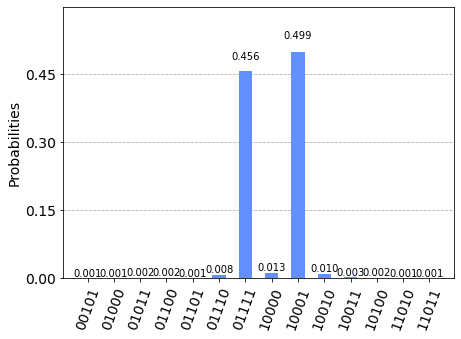

In [15]:
# Calculate PV by amplitude estimation
# Note: This provides quantum speed-up with 1/shots convergence
tic = time.time()
transpiled_qc_amp = transpile(qc_amp, aer_sim)
qobj_amp = assemble(transpiled_qc_amp)
shots=1000
job_amp = aer_sim.run(qobj_amp, shots=shots)
hist_amp = job_amp.result().get_counts()
toc = time.time()
plot_histogram(hist_amp)

In [16]:
# Extract the result
measured_str = max(hist_amp, key=hist_amp.get)
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)
theta = (measured_int/(2**t))*math.pi
print("Theta = %.5f" % theta)
pv = (1-(math.sin(theta)**2))*2**4 # recall that we measure amplitude of bad states, hence the "1-a"
print("PV = %.5f" % pv)

Register Output = 17
Theta = 1.66897
PV = 0.15372


In [17]:
print("CPU Time = %.5f" % (toc-tic))

CPU Time = 43.16196


This is the expected result, i.e. the value on 5 counting qubits that is closest to the value from Section 2

## 4. Calculating the PV by Iterative Phase Estimation

This section uses iterative phase estimation (according to Qiskit textbook, Lab 4) to calculate the PV. Unlike in QAE, the bits of the phase are estimated subsequently in IPE, beginning with the least significant bit.
The advantage of this approach is that it requires only a SINGLE counting qubit and hence significantly less of (currently) scarce qubit resources.
A disadvantage is that (unlike QAE) it cannot be parallelized. However, as the computation is dominated by the term $\mathcal{Q}^{2^n}$ and as $\sum_{n=0}^n 2^k = 2^{n+1}$, the time overhead is only around a factor 2 (indepedent of $n$).

In [18]:
def qcIPE(classicalBits, countingQuBits, algoQuBits):
    q = QuantumRegister(countingQuBits + algoQuBits)
    c = ClassicalRegister(classicalBits)

    ##1 Initialization
    qc_ipe = QuantumCircuit(q,c)
    # Apply Hadamard to ancilla qubits
    qc_ipe.h(0)
    # Apply A operator to algo register
    qc_ipe.append(woernerA(),range(countingQuBits, countingQuBits+algoQuBits))

    # Define controlled Q operators
    cQ = Q().to_gate()
    cQ.label = "Q"
    cQ = cQ.control()

    # Loop over bits to determine
    for b in range(classicalBits-1,-1,-1):
        ##2 Apply control-U operator
        for i in range(2**b):
            qc_ipe.append(cQ, [0] + [*range(countingQuBits, countingQuBits+algoQuBits)])
        ##3 Apply phase correction
        for j in range(1,classicalBits-b):
            qc_ipe.rz(-np.pi/2**(n-b-j), 0).c_if(c, j)
        ##4 measure the anscillar qubit in x-basis
        qc_ipe.h(0)
        qc_ipe.measure(q[0], c[classicalBits-1-b])
        ##5 reset the ancilla qubit
        qc_ipe.reset(q[0])
        qc_ipe.h(0)
    return qc_ipe


In [19]:
classicalBits = 5
countingQuBits = 1
algoQuBits = 8

qc_ipe = qcIPE(classicalBits, countingQuBits, algoQuBits)

qc_ipe.draw()

┌───┐                                                             »
q103_0: ┤ H ├───■─────■─────■─────■─────■─────■─────■─────■─────■─────■───»
        ├───┴┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐»
q103_1: ┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├»
        │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
q103_2: ┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├»
        │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
q103_3: ┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├»
        │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
q103_4: ┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├»
        │  A ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q ││  Q │»
q103_5: ┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├»
        │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
q103_6: ┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├»
        │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
q103_7: ┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├»
        │    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
q103_8: ┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├»
        └────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘»
  c0: 5/══════════════════════════════════════════════════════════════════»
                                                                          »
«                                            ┌───┐┌─┐     ┌───┐            »
«q103_0: ──■─────■─────■─────■─────■─────■───┤ H ├┤M├─|0>─┤ H ├──■─────■───»
«        ┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐└───┘└╥┘     └───┘┌─┴──┐┌─┴──┐»
«q103_1: ┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├──────╫───────────┤0   ├┤0   ├»
«        │    ││    ││    ││    ││    ││    │      ║           │    ││    │»
«q103_2: ┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├──────╫───────────┤1   ├┤1   ├»
«        │    ││    ││    ││    ││    ││    │      ║           │    ││    │»
«q103_3: ┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├──────╫───────────┤2   ├┤2   ├»
«        │    ││    ││    ││    ││    ││    │      ║           │    ││    │»
«q103_4: ┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├──────╫───────────┤3   ├┤3   ├»
«        │  Q ││  Q ││  Q ││  Q ││  Q ││  Q │      ║           │  Q ││  Q │»
«q103_5: ┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├┤4   ├──────╫───────────┤4   ├┤4   ├»
«        │    ││    ││    ││    ││    ││    │      ║           │    ││    │»
«q103_6: ┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├──────╫───────────┤5   ├┤5   ├»
«        │    ││    ││    ││    ││    ││    │      ║           │    ││    │»
«q103_7: ┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├──────╫───────────┤6   ├┤6   ├»
«        │    ││    ││    ││    ││    ││    │      ║           │    ││    │»
«q103_8: ┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├──────╫───────────┤7   ├┤7   ├»
«        └────┘└────┘└────┘└────┘└────┘└────┘      ║           └────┘└────┘»
«  c0: 5/══════════════════════════════════════════╩═══════════════════════»
«                                                  0                       »
«                                            ┌───────────┐┌───┐┌─┐     ┌───┐»
«q103_0: ──■─────■─────■─────■─────■─────■───┤ Rz(-π/16) ├┤ H ├┤M├─|0>─┤ H ├»
«        ┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐└─────╥─────┘└───┘└╥┘     └───┘»
«q103_1: ┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├──────╫────────────╫───────────»
«        │    ││    ││    ││    ││    ││    │      ║            ║           »
«q103_2: ┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├──────╫────────────╫───────────»
«        │    ││    ││    ││    ││    ││    │      ║            ║           »
«q103_3: ┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├──────╫────────────╫───────────»
«        │    ││    ││    ││    ││    ││    │      ║            ║           »
«q103_4: ┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├──────╫────────────╫───────────»
«        │  Q │

In [ ]:
tic2 = time.time()
transpiled_qc_ipe = transpile(qc_ipe, aer_sim)
qobj_ipe = assemble(transpiled_qc_ipe)
shots=1000
job_ipe = aer_sim.run(qobj_ipe, shots=shots)
hist_ipe = job_ipe.result().get_counts()
toc2 = time.time()
plot_histogram(hist_ipe)

In [ ]:
# Extract the result
measured_str = max(hist_ipe, key=hist_ipe.get)
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)
theta = (measured_int/(2**classicalBits))*math.pi
print("Theta = %.5f" % theta)
pv = (1-(math.sin(theta)**2))*2**4 # recall that we measure amplitude of bad states, hence the "1-a"
print("PV = %.5f" % pv)

In [ ]:
print("CPU Time = %.5f" % (toc2-tic2))

## 5. Remarks

a) The explicit encoding of the distribution is preventing any quantum speed-up here. As mentioned in Vazquez/Woerner, the distribution needs to be encoded by quantum arithmetics

b) The spin-echo circuit optimization as described in Sectin 4 of that paper is also not implemented yet.